In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
import torch.nn as nn
import torchsummary
import torch
import torch.optim as optim

from dgzc.dataset import DGZCAutoEncoderDataset, DGZCClassifierDataset, DGZCInferenceDataset
from dgzc.autoencoder import Encoder, Decoder, AutoEncoderFaceImages
from dgzc.classifier import ClassificationBackbone, AutoEncoderClassifierAmalgamation

In [2]:
data_path = "/home/shivam/2021-22-2/ML4CE/Assignments/Assignment3/Driver-Gaze-Zone-Classification/data/gaze_dataset"
# dataset_auto_enc = DGZCAutoEncoderDataset(data_path, size=(200, 200))
dataset_classifier = DGZCClassifierDataset(data_path, size=(200, 200))
# dataset_inference = DGZCInferenceDataset(data_path, size=(200, 200))

In [3]:
dataloader = DataLoader(dataset_classifier, batch_size = 10, shuffle = True, num_workers=5)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
data_len = len(dataloader)
log_n = int(data_len//3)

In [6]:
model = AutoEncoderClassifierAmalgamation()
model.to(device)

AutoEncoderClassifierAmalgamation(
  (encoder): Encoder(
    (conv1): Conv2DNormActivation(
      (0): Conv2d(3, 5, kernel_size=(5, 5), stride=(2, 2))
      (1): SELU()
    )
    (conv2): Conv2DNormActivation(
      (0): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1), bias=False)
      (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
    (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2DNormActivation(
      (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
      (1): SELU()
    )
    (conv4): Conv2DNormActivation(
      (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
      (1): SELU()
    )
    (conv5): Conv2DNormActivation(
      (0): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
    (conv6): Conv2DNormActivation(
      (0): Co

In [8]:
load_prev_auto_enc_state = False
load_prev_model_state = True
if load_prev_auto_enc_state:
    model.encoder.load_state_dict(torch.load('./encoder_state'))
    model.decoder.load_state_dict(torch.load('./decoder_state'))
elif load_prev_model_state:
    model.load_state_dict(torch.load('./amalgam_model'))

In [9]:
torchsummary.summary(model, (3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 98, 98]             380
              SELU-2            [-1, 5, 98, 98]               0
            Conv2d-3           [-1, 10, 94, 94]           1,250
       BatchNorm2d-4           [-1, 10, 94, 94]              20
              SELU-5           [-1, 10, 94, 94]               0
         MaxPool2d-6           [-1, 10, 47, 47]               0
            Conv2d-7           [-1, 20, 45, 45]           1,820
              SELU-8           [-1, 20, 45, 45]               0
            Conv2d-9           [-1, 20, 43, 43]           3,620
             SELU-10           [-1, 20, 43, 43]               0
           Conv2d-11           [-1, 30, 41, 41]           5,400
      BatchNorm2d-12           [-1, 30, 41, 41]              60
             SELU-13           [-1, 30, 41, 41]               0
           Conv2d-14           [-1, 40,

In [10]:
criterion1 =  nn.MSELoss() # Reconstruction Loss function
criterion2 =  nn.CrossEntropyLoss() # Classification Loss function
params_list = model.parameters() # model parameters
optimizer = optim.AdamW(params_list, lr = 0.0007, weight_decay=0.0001)

In [18]:
def compute_loss(dl, model, crt1, crt2):
    total_loss = 0.
    cnt = 0
    total = 0
    correct = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data, target in dl:
            data = data.to(device)
            target = target.to(device)
            
            # calculate outputs by running images through the network
            cls, recon_img = model(data)

            loss = crt2(cls, target)
            
            total_loss += loss.item()
            
            predictions = cls.max(dim=1)[1]
            total += predictions.size(0)
            correct += (predictions == target).sum().item()
            cnt += 1
            
    return [total_loss/cnt, correct/total]

In [12]:
rll = []
total_loss = []

In [13]:
model.train()

AutoEncoderClassifierAmalgamation(
  (encoder): Encoder(
    (conv1): Conv2DNormActivation(
      (0): Conv2d(3, 5, kernel_size=(5, 5), stride=(2, 2))
      (1): SELU()
    )
    (conv2): Conv2DNormActivation(
      (0): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1), bias=False)
      (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
    (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2DNormActivation(
      (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
      (1): SELU()
    )
    (conv4): Conv2DNormActivation(
      (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
      (1): SELU()
    )
    (conv5): Conv2DNormActivation(
      (0): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
    (conv6): Conv2DNormActivation(
      (0): Co

In [19]:
for epoch in range(50):
    running_loss = 0.
    total = 0.
    correct = 0.
    for i, (data, target) in enumerate(dataloader):
        data = data.to(device) # Move data to target device
        target = target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        cls, recon = model(data)
        
        loss = criterion2(cls, target)
        
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
        predictions = cls.max(dim=1)[1]
        total += predictions.size(0)
        correct += (predictions == target).sum().item()
        
        if i%log_n == log_n-1:
            rll += [epoch, i, running_loss]
            print(f'Epoch : {epoch}, Iteration : {i},Running loss : {running_loss/log_n}, Train Accuracy : {correct/total}')
            running_loss, total, correct = 0, 0, 0
    if epoch%10 == 0:
        total_loss += [compute_loss(dataloader, model, criterion1, criterion2)]
        print(f'Total loss : {total_loss[-1]}')

Epoch : 0, Iteration : 82,Running loss : 1.089362910713058, Train Accuracy : 0.8132530120481928
Epoch : 0, Iteration : 165,Running loss : 1.122600533157946, Train Accuracy : 0.7783132530120482
Epoch : 0, Iteration : 248,Running loss : 1.0768490211073174, Train Accuracy : 0.8289156626506025
Total loss : [1.0820360839366914, 0.8212]
Epoch : 1, Iteration : 82,Running loss : 1.0935442993439823, Train Accuracy : 0.810843373493976
Epoch : 1, Iteration : 165,Running loss : 1.1254882891494107, Train Accuracy : 0.7795180722891566
Epoch : 1, Iteration : 248,Running loss : 1.1308972957622574, Train Accuracy : 0.7710843373493976
Epoch : 2, Iteration : 82,Running loss : 1.113082107291164, Train Accuracy : 0.7903614457831325
Epoch : 2, Iteration : 165,Running loss : 1.074354562414698, Train Accuracy : 0.8265060240963855
Epoch : 2, Iteration : 248,Running loss : 1.0808332971779697, Train Accuracy : 0.8253012048192772
Epoch : 3, Iteration : 82,Running loss : 1.0706725522696254, Train Accuracy : 0.8373

Epoch : 27, Iteration : 248,Running loss : 1.0546547239085278, Train Accuracy : 0.8493975903614458
Epoch : 28, Iteration : 82,Running loss : 1.0551525146128184, Train Accuracy : 0.8493975903614458
Epoch : 28, Iteration : 165,Running loss : 1.0657242608357624, Train Accuracy : 0.8373493975903614
Epoch : 28, Iteration : 248,Running loss : 1.0593461006520741, Train Accuracy : 0.8457831325301205
Epoch : 29, Iteration : 82,Running loss : 1.058055594024888, Train Accuracy : 0.8457831325301205
Epoch : 29, Iteration : 165,Running loss : 1.0587066555597695, Train Accuracy : 0.846987951807229
Epoch : 29, Iteration : 248,Running loss : 1.0783515026770443, Train Accuracy : 0.8253012048192772
Epoch : 30, Iteration : 82,Running loss : 1.0726945651582924, Train Accuracy : 0.8349397590361446
Epoch : 30, Iteration : 165,Running loss : 1.0437238008142955, Train Accuracy : 0.8614457831325302
Epoch : 30, Iteration : 248,Running loss : 1.0738079993121594, Train Accuracy : 0.8313253012048193
Total loss : [1

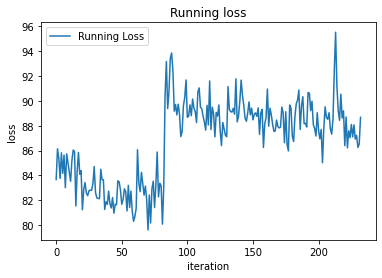

In [20]:
plt.plot(np.array(rll).reshape((-1, 3))[:, 2], label='Running Loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Running loss')
plt.legend()
plt.show()

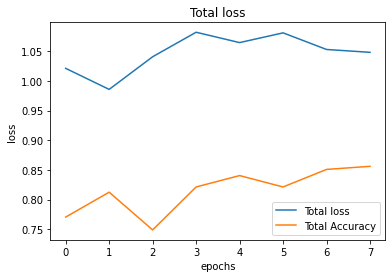

In [21]:
plt.plot(total_loss, label=['Total loss', 'Total Accuracy'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Total loss')
plt.legend()
plt.show()

In [22]:
torch.save(model.encoder.state_dict(), './encoder_state_amalgam2')
torch.save(model.decoder.state_dict(), './decoder_state_amalgam2')
torch.save(model.state_dict(), './amalgam_model2')

In [30]:
model.eval()

AutoEncoderFaceImages(
  (encoder): Encoder(
    (conv1): Conv2DNormActivation(
      (0): Conv2d(3, 5, kernel_size=(5, 5), stride=(2, 2))
      (1): SELU()
    )
    (conv2): Conv2DNormActivation(
      (0): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1), bias=False)
      (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
    (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2DNormActivation(
      (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
      (1): SELU()
    )
    (conv4): Conv2DNormActivation(
      (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
      (1): SELU()
    )
    (conv5): Conv2DNormActivation(
      (0): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
    (conv6): Conv2DNormActivation(
      (0): Conv2d(30, 40,

In [31]:
sample_input, target = iter(dataloader).next()

In [32]:
sample_input = sample_input.to(device)

In [33]:
sample_output = model(sample_input)

In [34]:
imgs = sample_output.detach().cpu().permute(0, 2, 3, 1).numpy()
src_imgs = sample_input.detach().cpu().permute(0, 2, 3, 1).numpy()

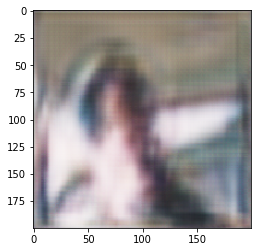

In [36]:
plt.imshow(imgs[10, ::])
plt.show()

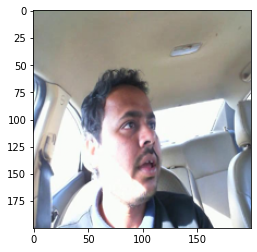

In [38]:
plt.imshow(src_imgs[10, ::])
plt.show()